# $\underline{\text{RAMP: Global Ocean Waves Analysis and Forecast}}$

## Prediction of wave direction based on spectral peak from the instrument SWIM-nadir of CFOSAT Mission


GROUP 19: Pavlo Poliuha, Junjie Chen, Pablo Mollá, Quang Phuoc Ho, Kumari Nageeta, Louis Betzer



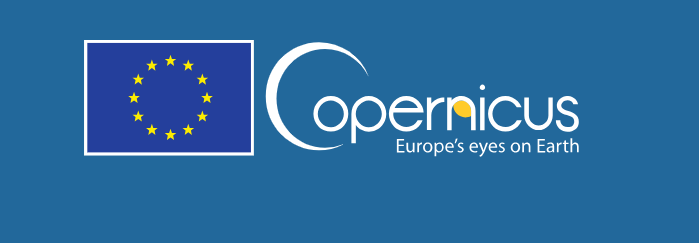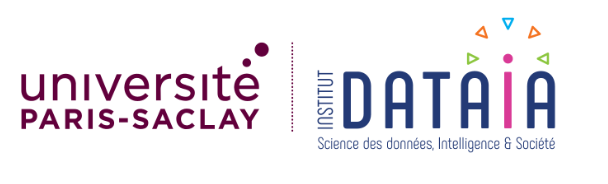

## Table of Contents

* [Introduction](#introduction)
* [Requirements](#requirements)
* [The dataset](#dataset)
* [Data exploration](#data_exploration)
* [Base model](#base_model)
* [Submitting on RAMP](#submitting)



# Introduction <a class="anchor" id="introduction"></a>

The Météo-France's global ocean system gives daily updates and 10-day predictions for sea surface waves across the world, using a detailed 1/12 degree resolution. Every three hours, it provides data on various wave characteristics like height, period, direction, and Stokes drift. It also separates the data into wind waves and two types of swell waves (primary and secondary).

This system is powered by the MFWAM wave model, a sophisticated tool that builds on the ECWAM-IFS-38R2 computing code and uses specific techniques developed by Ardhuin and others in 2010 for better accuracy. In November 2014, the MFWAM model received updates from the "my wave" European research project, enhancing its capabilities. It uses detailed global topography (ETOPO2/NOAA) to create an accurate ocean floor model and operates on a unique grid that changes size closer to the poles and is more uniform at the equator.

MFWAM runs with data from the IFS-ECMWF atmospheric system, including wind analyses every six hours and wind forecasts every three hours. It analyzes waves in 24 different directions and 30 frequencies, ranging from 0.035 Hz to 0.58 Hz, and incorporates satellite altimeter data every six hours. The system updates its analyses four times daily and offers 10-day forecasts at 0:00 UTC. It also categorizes swells into primary and secondary types for detailed wave predictions.

Given the detailed features available in the dataset, which include various measurements related to sea surface wave heights, wave periods, wave directions, and Stokes drift velocities, there are several compelling regression tasks we could undertake. These tasks can help in understanding, predicting, and analyzing wave dynamics for various applications such as navigation, coastal engineering, and climate research.

The goal of the Data Challenge is to predict wave principal direction at spectral peak (VPED).

*Objective*: Use environmental and wave spectral parameters to predict the wave principal direction at spectral peak (VPED), which is a key variable for marine navigation and offshore operations.

*Input Features*: Wind wave heights (VHM0, VHM0_WW), primary and secondary swell wave heights (VHM0_SW1, VHM0_SW2), wave periods (like VTM10, VTM02, VTPK), and direction (VMDR).

*Output Variable*: Wave principal direction at spectral peak (VPED).

# Requirements <a class="anchor" id="requirements"></a>

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Download Data

In [2]:
# Uncomment the following line to download data:
#!python download_data.py

# The dataset <a class="anchor" id="dataset"></a>

$\underline{\text{Dataset Description}}:$

  The dataset comprises 17 various features detailed as follows:

  - $\textbf{VTM10:}$ Spectral moments (-1,0) wave period (Tm-10).
  - $\textbf{VTM02:}$ Spectral moments (0,2) wave period (Tm02).
  - $\textbf{VTPK:}$ Wave period at spectral peak / peak period (Tp).
  - $\textbf{VMDR:}$ Mean wave direction from (Mdir).
  - $\textbf{VHM0:}$ Spectral significant wave height (Hm0).
  - $\textbf{VCMX:}$ Maximum crest trough wave height (Hc,max).
  - $\textbf{VSDX:}$ Stokes drift U.
  - $\textbf{VSDY:}$ Stokes drift V.
  - $\textbf{VHM0-WW:}$ Spectral significant wind wave height.
  - $\textbf{VTM01-WW:}$ Spectral moments (0,1) wind wave period.
  - $\textbf{VMDR-WW:}$ Mean wind wave direction from.
  - $\textbf{VHM0-SW1:}$ Spectral significant primary swell wave height.
  - $\textbf{VTM01-SW1:}$ Spectral moments (0,1) primary swell wave period.
  - $\textbf{VMDR-SW1:}$ Mean primary swell wave direction from.
  - $\textbf{VHM0-SW2:}$ Spectral significant secondary swell wave height.
  - $\textbf{VTM01-SW2:}$ Spectral moments (0,1) secondary swell wave period.
  - $\textbf{VMDR-SW2:}$ Mean secondary swell wave direction from.

And the target value that we are trying to predict:

  - $\textbf{VPED:}$ Wave principal direction at spectral peak (Mdir).

# Data Exploration <a class="anchor" id="data_exploration"></a>

Here you need to change the path according to your system to open the train and test datasets.

### Train data

In [3]:
train_df = pd.read_csv('./data/train.csv')
train_df

,VHM0,VHM0_WW,VTM01_SW1,VTM01_SW2,VTM10,VHM0_SW1,VHM0_SW2,VTPK,VSDX,VSDY,VCMX,VTM02,VTM01_WW,VMDR_WW,VMDR_SW1,VMDR_SW2,VMDR,VPED
0,1.98,0.42,8.120000,7.840000,8.570000,1.32,0.89,9.780000,-0.05,0.02,3.72,6.13,2.57,124.970000,282.919980,142.260010,318.200000,262.5
1,1.98,0.97,7.230000,7.190000,7.520000,1.60,0.59,9.389999,-0.10,-0.05,3.73,5.41,3.84,59.520004,78.670006,352.580020,67.260000,82.5
2,4.83,2.84,10.320000,10.700000,10.420000,3.51,1.45,13.000000,0.14,-0.14,8.97,8.02,6.46,320.740000,274.820000,215.450000,288.120000,277.5
3,3.61,1.05,9.120000,7.610000,8.929999,2.00,1.83,9.290000,0.13,-0.05,6.78,7.16,4.02,294.830000,228.840000,263.700000,275.750000,247.5
4,4.14,3.03,8.720000,8.679999,8.710000,2.39,1.14,9.590000,0.15,-0.12,7.84,7.07,6.66,311.360000,259.380000,182.210000,289.610000,262.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166080,2.72,0.55,8.139999,5.070000,9.349999,2.61,0.49,10.730000,0.09,-0.01,5.09,6.88,2.94,292.740000,238.910000,44.680008,241.780000,232.5
166081,1.61,0.21,5.940000,4.680000,7.330000,1.00,0.73,7.340000,0.02,-0.04,3.05,5.48,2.01,319.599980,10.730011,340.820000,321.120000,7.5
166082,0.61,0.00,9.510000,4.340000,8.950000,0.46,0.39,11.719999,-0.01,0.00,1.13,6.28,0.00,270.710000,163.760000,67.220000,125.850006,157.5
166083,1.68,0.00,6.550000,14.080000,9.450000,1.02,0.70,9.290000,0.02,0.01,3.12,6.82,0.00,7.809998,247.519990,235.860000,212.170000,217.5


### Column statistics

In [4]:
train_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166085 entries, 0 to 166084
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   VHM0       166085 non-null  float64
 1   VHM0_WW    166085 non-null  float64
 2   VTM01_SW1  166085 non-null  float64
 3   VTM01_SW2  166085 non-null  float64
 4   VTM10      166085 non-null  float64
 5   VHM0_SW1   166085 non-null  float64
 6   VHM0_SW2   166085 non-null  float64
 7   VTPK       166085 non-null  float64
 8   VSDX       166085 non-null  float64
 9   VSDY       166085 non-null  float64
 10  VCMX       166085 non-null  float64
 11  VTM02      166085 non-null  float64
 12  VTM01_WW   166085 non-null  float64
 13  VMDR_WW    166085 non-null  float64
 14  VMDR_SW1   166085 non-null  float64
 15  VMDR_SW2   166085 non-null  float64
 16  VMDR       166085 non-null  float64
 17  VPED       166085 non-null  float64
dtypes: float64(18)
memory usage: 22.8 MB


### Test data

In [5]:
test_df = pd.read_csv('./data/test.csv')
test_df

,VHM0,VHM0_WW,VTM01_SW1,VTM01_SW2,VTM10,VHM0_SW1,VHM0_SW2,VTPK,VSDX,VSDY,VCMX,VTM02,VTM01_WW,VMDR_WW,VMDR_SW1,VMDR_SW2,VMDR,VPED
0,3.27,0.22,8.630000,12.160000,10.46,3.18,0.68,11.969999,0.07,0.05,6.04,8.01,2.03,223.940000,235.97000,156.600000,233.10000,232.5
1,3.35,1.25,8.770000,16.039999,9.70,3.11,0.04,11.849999,0.13,-0.04,6.26,7.18,4.36,295.190000,268.01000,98.260000,272.01000,262.5
2,1.28,0.51,10.190000,8.520000,9.36,0.96,0.34,12.679999,-0.03,-0.06,2.44,5.15,2.77,20.620010,186.86000,282.270000,174.59000,187.5
3,1.43,0.70,8.480000,9.700000,8.04,0.90,0.59,12.160000,-0.08,0.04,2.74,4.88,3.26,113.390000,161.04001,180.320000,156.16000,202.5
4,3.91,2.89,9.880000,12.120000,9.32,1.87,0.97,10.700000,0.19,-0.05,7.32,7.08,6.58,284.729980,247.15000,221.940000,278.59000,277.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41516,3.13,2.05,8.099999,6.090000,8.05,2.34,0.15,9.700000,0.07,-0.15,5.88,6.22,5.30,340.160000,265.22000,41.770004,297.62000,277.5
41517,1.46,0.00,7.160000,10.139999,8.59,1.45,0.12,9.309999,-0.01,0.02,2.69,6.98,0.00,216.440000,150.39000,67.370000,149.98000,142.5
41518,2.79,0.47,13.969999,6.000000,13.69,2.30,1.42,17.130000,-0.03,-0.08,5.20,8.32,2.77,29.779999,317.84000,1.720001,328.90000,322.5
41519,3.19,2.42,11.530000,6.970000,8.48,1.19,1.02,7.780000,-0.15,-0.09,6.14,6.34,5.88,57.960000,332.70000,8.980011,39.90001,337.5


### Visualization of Target Feature

Mean primary swell wave direction (VMDR_SW1) vs Wave principal direction at spectral peak (VPED).

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


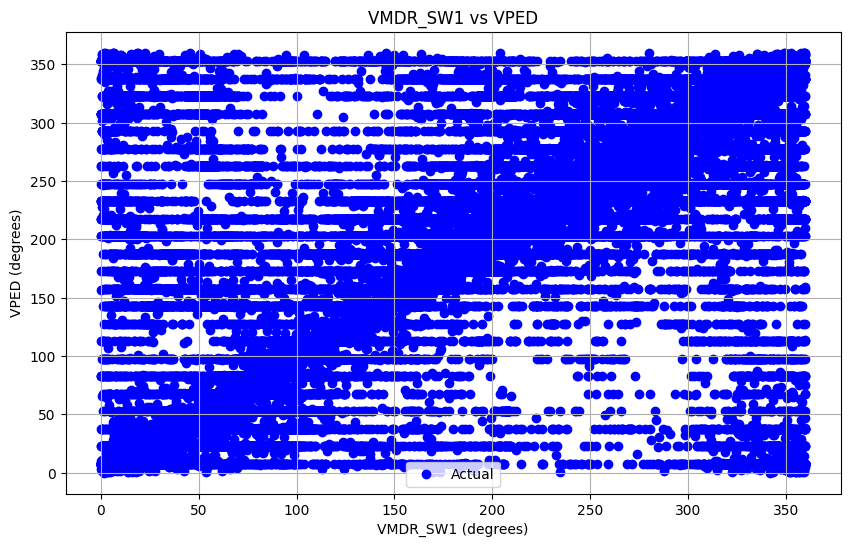

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df["VMDR_SW1"], train_df["VPED"], color='blue', label='Actual')
plt.title('VMDR_SW1 vs VPED')
plt.xlabel('VMDR_SW1 (degrees)')
plt.ylabel('VPED (degrees)')
plt.legend()
plt.grid(True)
plt.show()

### Data Correlation Matrices

Correlation Matrix with Seaborn (Whole set of Features)

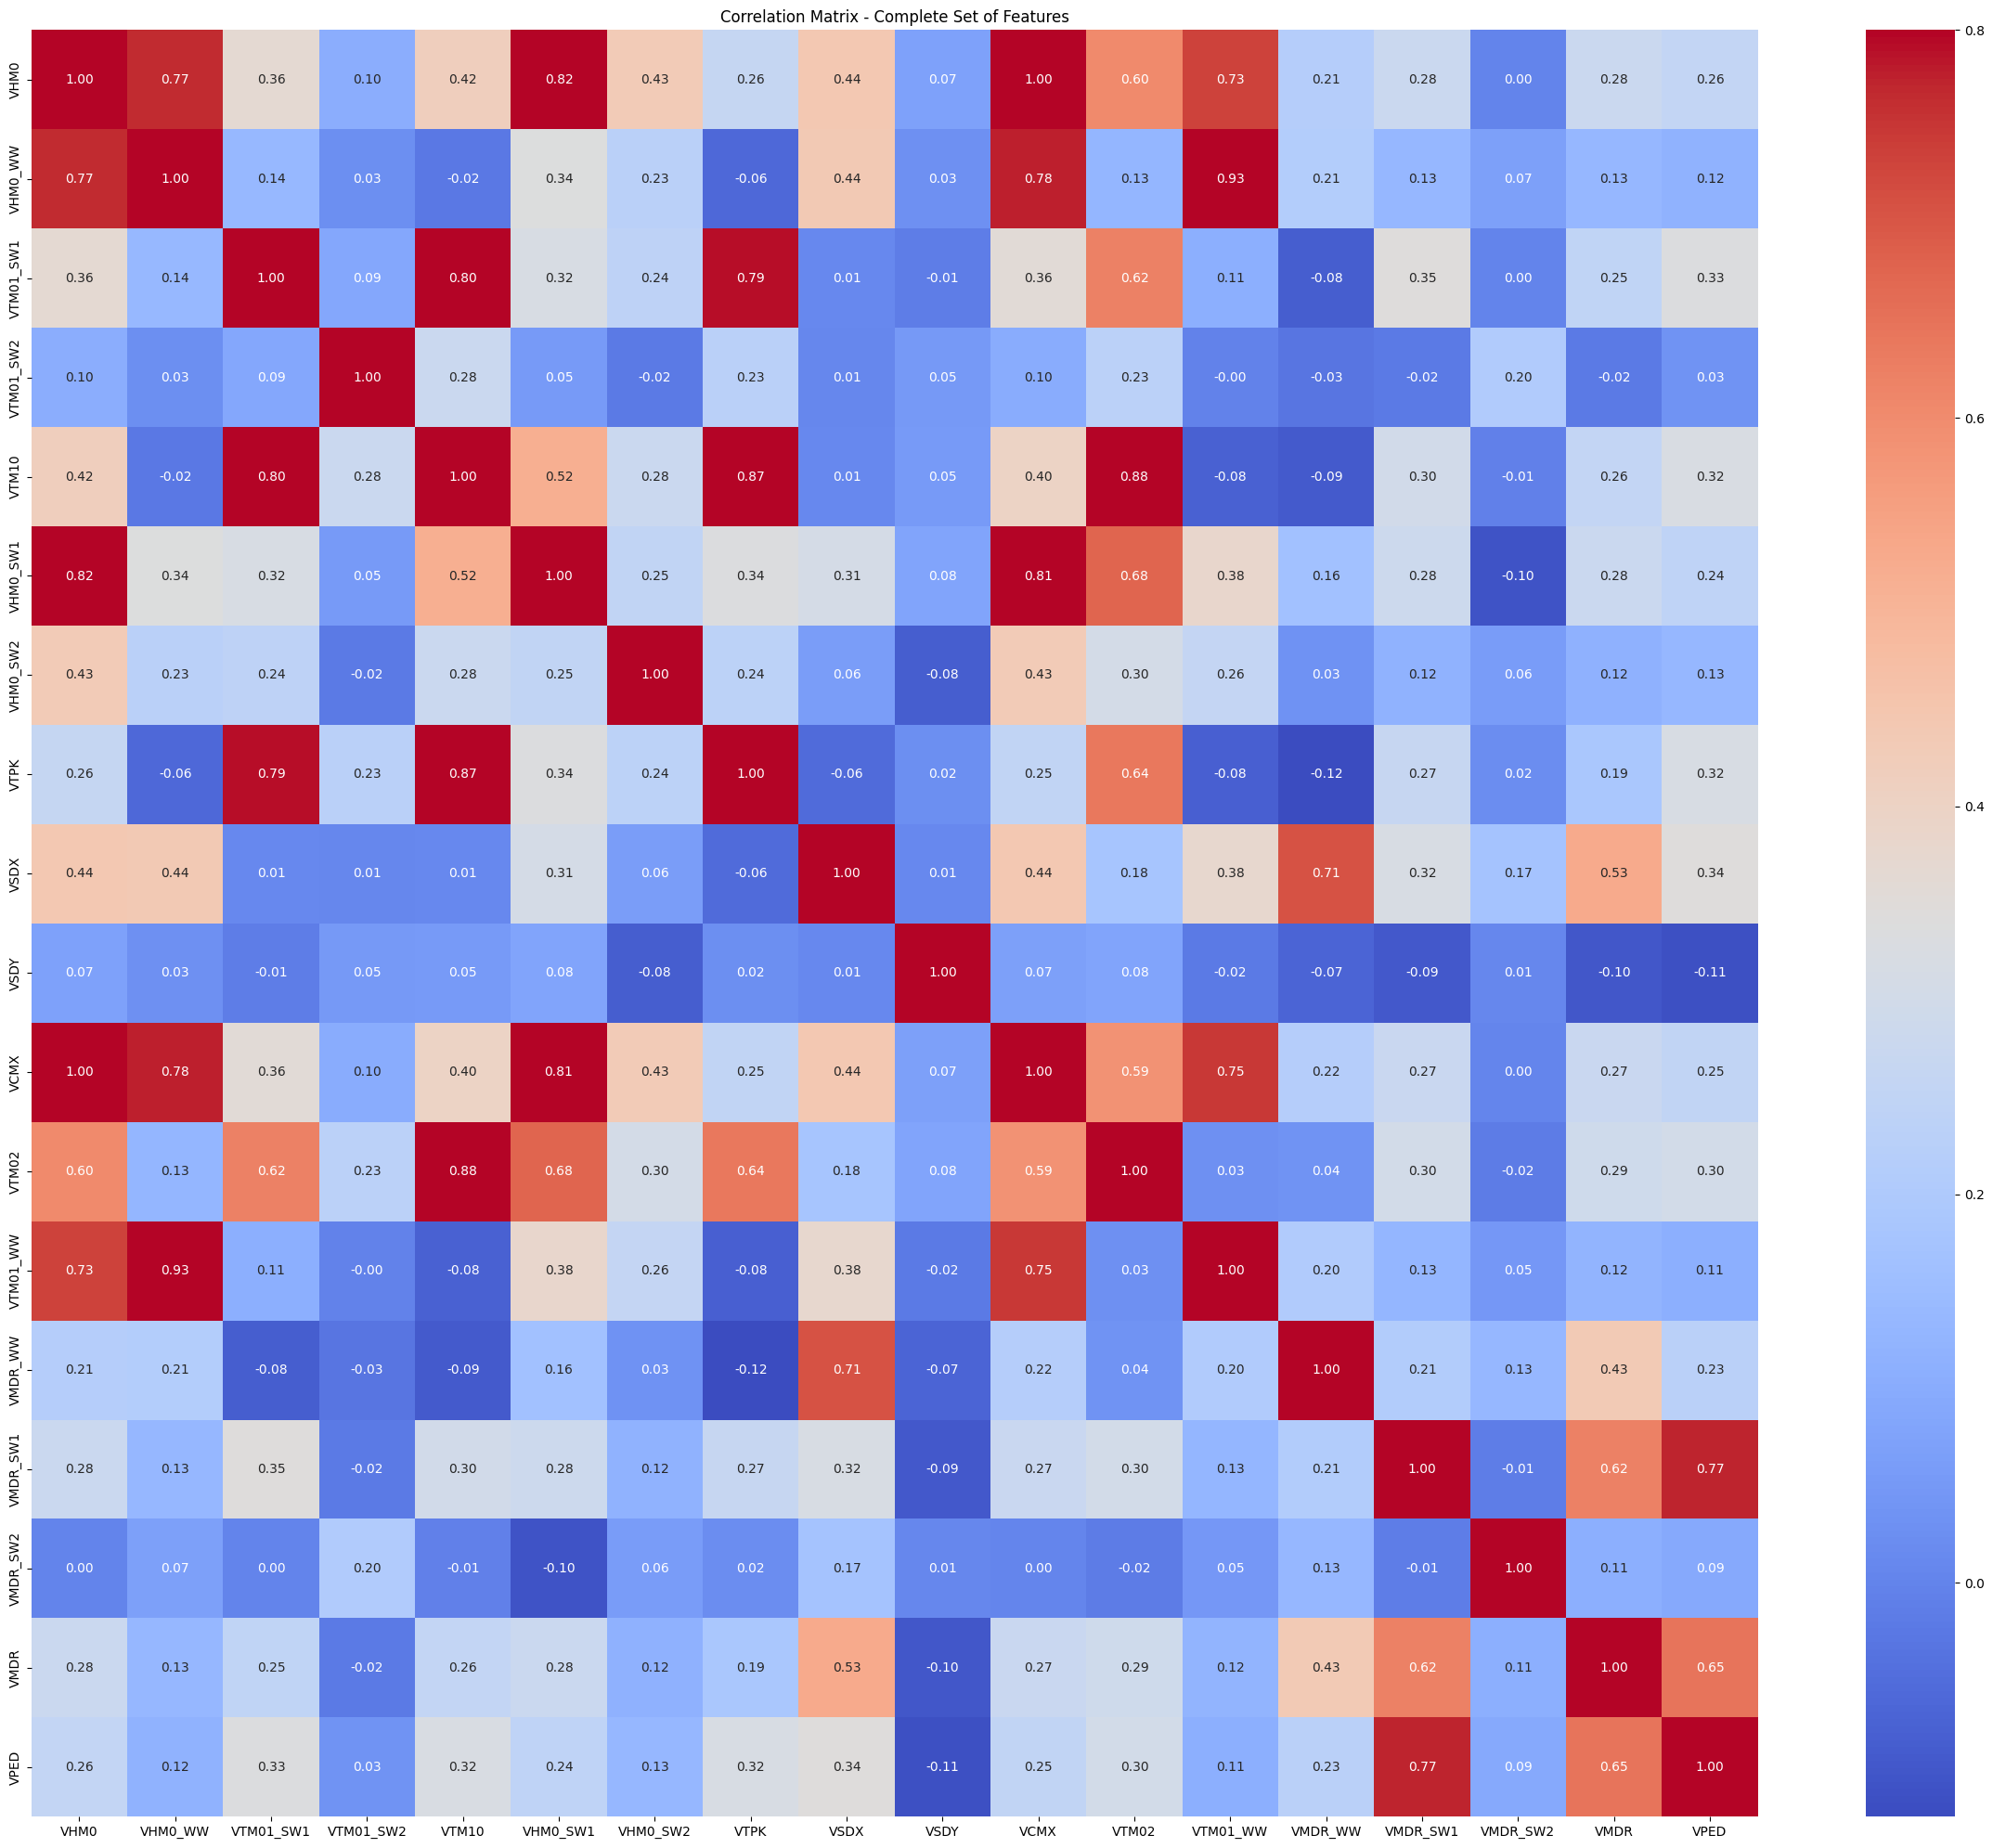

In [7]:
waves_correlation_matrix = train_df.corr()

# Plot the heatmap
plt.figure(figsize=(30,25))
sns.heatmap(waves_correlation_matrix, vmax=0.8, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix - Complete Set of Features")
plt.show()

The most correlated features based on the correlation matrix above

In [8]:
corr_pairs = waves_correlation_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
corr_pairs = corr_pairs[corr_pairs['Variable1'] != corr_pairs['Variable2']]
corr_pairs['AbsCorrelation'] = corr_pairs['Correlation'].abs()
sorted_pairs = corr_pairs.sort_values('AbsCorrelation', ascending=False)
top_pairs = sorted_pairs.drop_duplicates(subset=['AbsCorrelation'])
top_pairs

,Variable1,Variable2,Correlation,AbsCorrelation
10,VHM0,VCMX,0.999451,0.999451
30,VHM0_WW,VTM01_WW,0.934502,0.934502
83,VTM10,VTM02,0.881344,0.881344
79,VTM10,VTPK,0.868165,0.868165
5,VHM0,VHM0_SW1,0.818867,0.818867
...,...,...,...,...
62,VTM01_SW2,VSDX,0.005813,0.005813
219,VTM01_WW,VTM01_SW2,-0.004185,0.004185
195,VCMX,VMDR_SW2,0.003542,0.003542
15,VHM0,VMDR_SW2,0.001438,0.001438


Correlation matrix of the top 6 most correlated features with the target value (VPED)

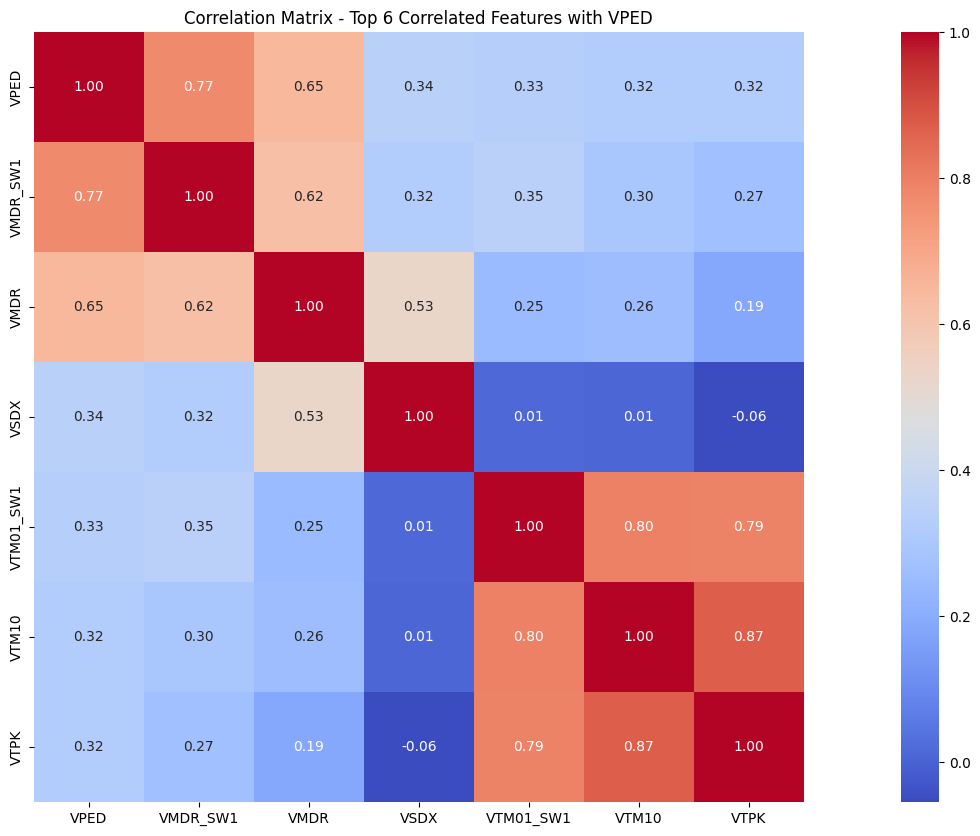

In [9]:
k = 7
plt.figure(figsize=(25,10))
cols = waves_correlation_matrix.nlargest(k, 'VPED')['VPED'].index
vped_correlation_matrix = np.corrcoef(train_df[cols].values.T)
hm = sns.heatmap(vped_correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap='coolwarm')
plt.title("Correlation Matrix - Top 6 Correlated Features with VPED")
plt.show()

Correlation Plots of the top 6 most correlated features taken from the previous matrix (VMDR_SW1, VMDR, VSDX, VTM01_SW1, VTM10, VTPK)

<Figure size 2000x800 with 0 Axes>

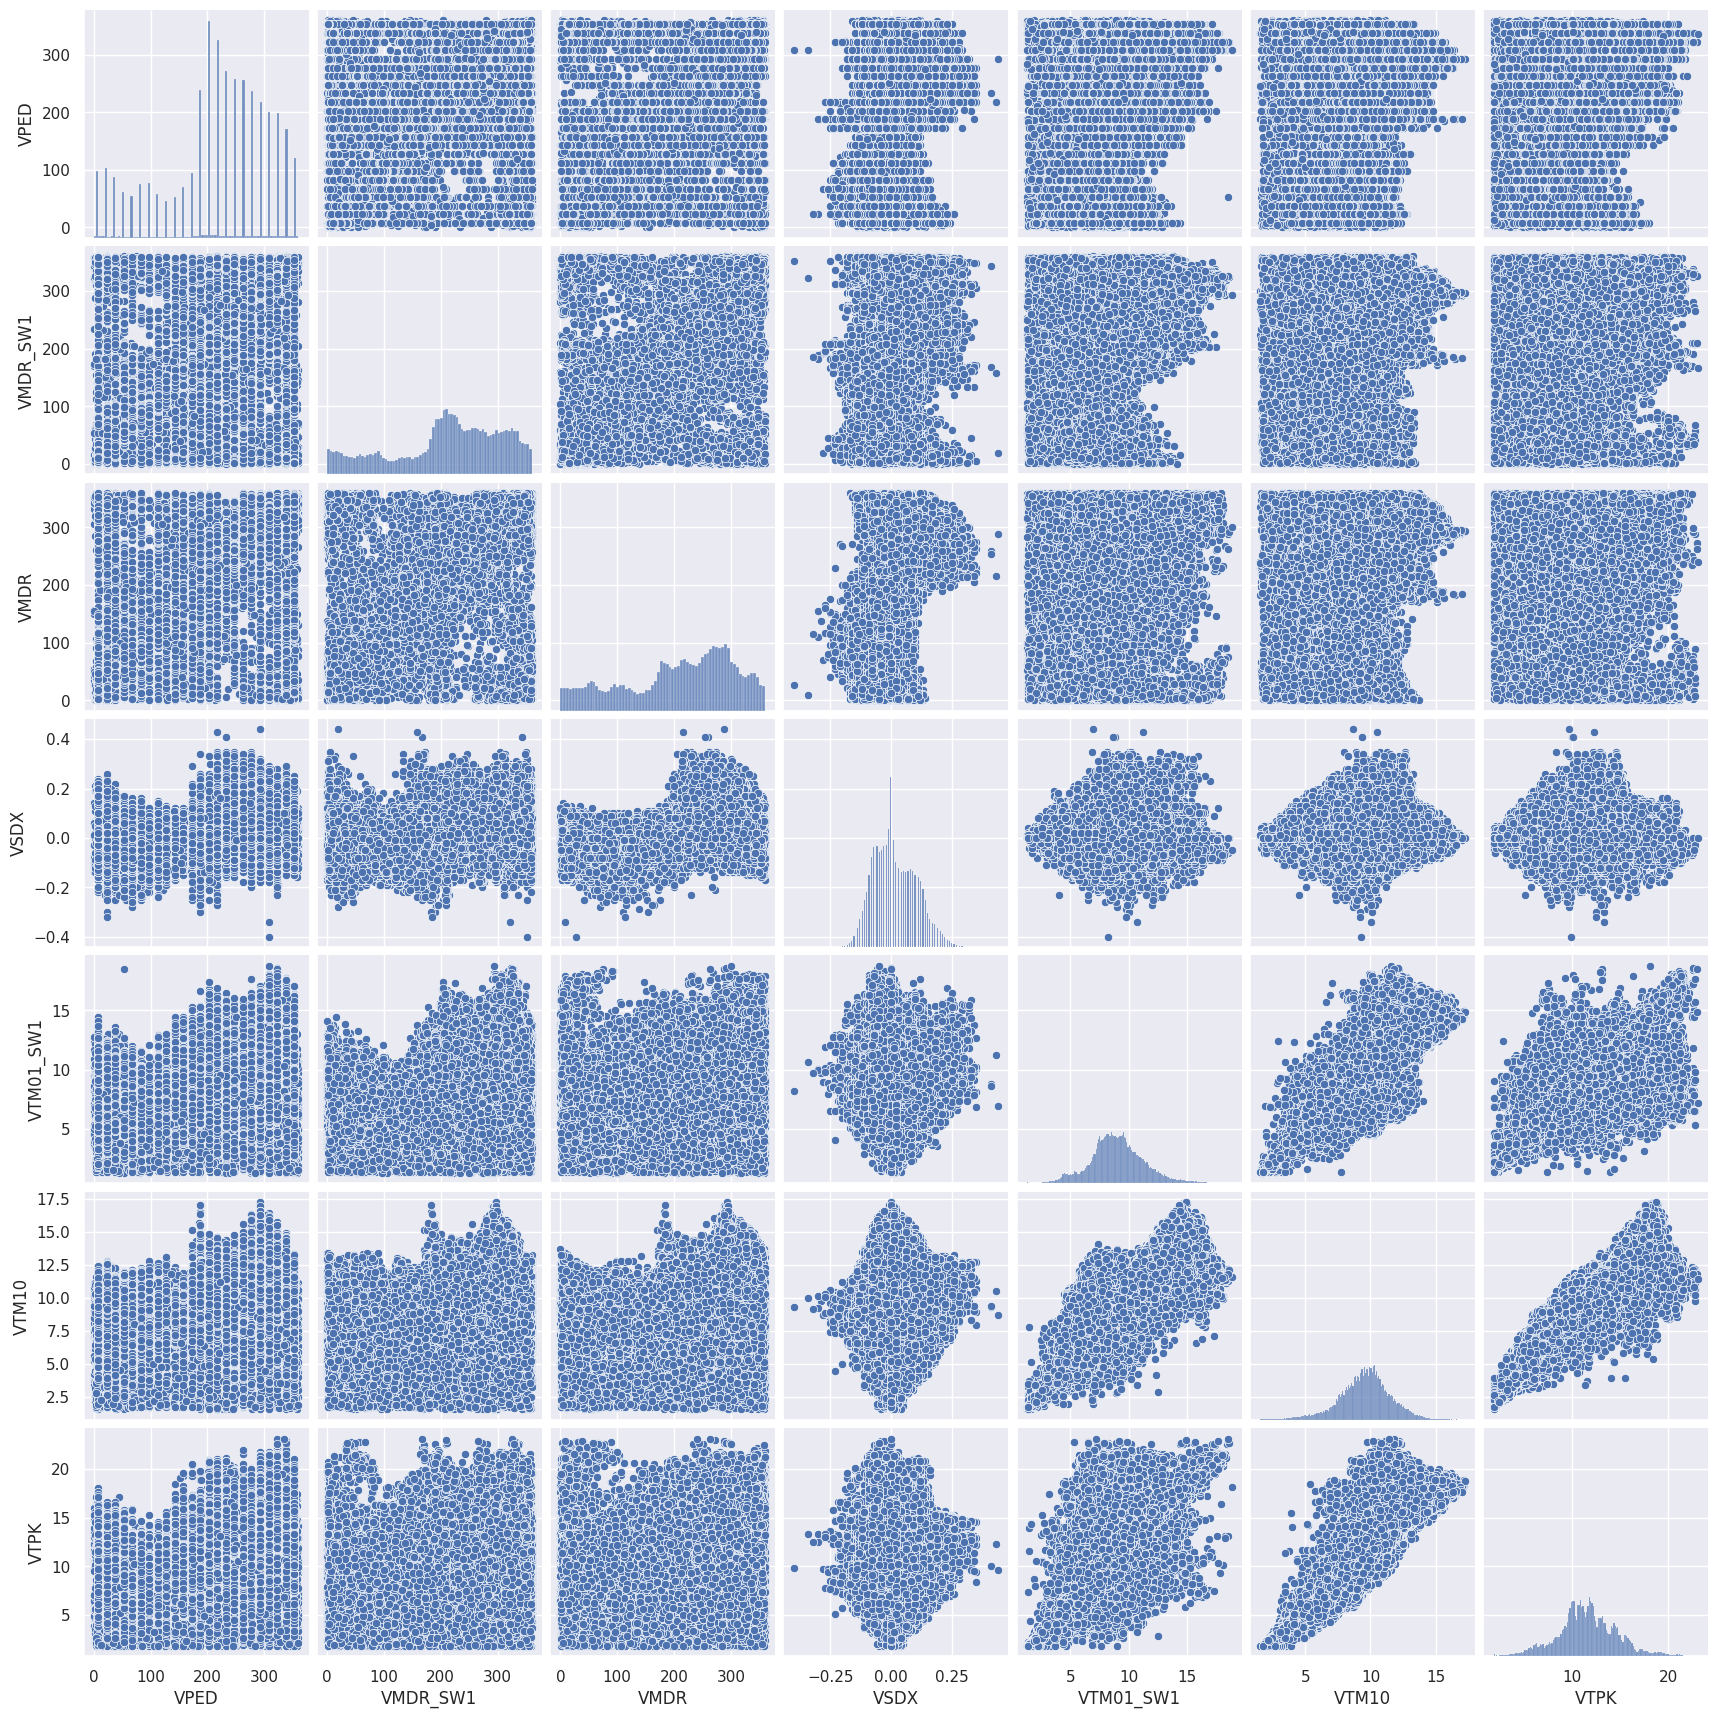

In [10]:
sns.set()
plt.figure(figsize=(20,8))
cols = ['VPED', 'VMDR_SW1', 'VMDR', 'VSDX', 'VTM01_SW1', 'VTM10', 'VTPK']
sns.pairplot(train_df[cols], height = 2.5)
plt.show()

## Feature Engineering

### Feature Selection

The following features are chosen to train the regressor as a baseline model according to the top 6 most correlated.
Let's define these features in simpler terms and explain the units of measure:

- $\underline{\text{Primary Swell Wave Period}}$ (<font color='red'>VTM01_SW1</font>)

  This is the **average time between successive primary swell waves**. Swell waves are longer, more uniform waves that can travel long distances from where they were originally generated by strong winds.

  <font color='blue'>Unit of Measure</font>: Seconds (s)

- $\underline{\text{Mean Primary Swell Wave Direction}}$ (<font color='red'>VMDR_SW1</font>)

  This indicates the **average direction from which primary swell waves are coming**. It helps to identify the direction that swell waves are moving across the ocean.

  <font color='blue'>Unit of Measure</font>: Degrees (°)

- $\underline{\text{Mean Wave Direction}}$ (<font color='red'>VMDR</font>)

  This measures the **average direction from which all waves are coming**. It's a general indication of wave direction, combining all wave types.

  <font color='blue'>Unit of Measure</font>: Degrees (°)

- $\underline{\text{Wave Period at Spectral Peak}}$ (<font color='red'>VTPK</font>)

  This refers to the **time interval between the most energetic waves in the sea state**. It's measured at the spectral peak, which is the point where the energy of the wave spectrum is maximum.
  
  <font color='blue'>Unit of Measure</font>: Seconds (s)

- $\underline{\text{Complex Spectral Moments of the Wave Period}}$ (<font color='red'>VTM10</font>)

  This is a **more complex measure of wave period**. It gives a measure that is influenced by the entire range of wave periods present, not just the dominant or peak period.

  <font color='blue'>Unit of Measure</font>: Seconds (s)


- $\underline{\text{Stokes Drift Velocity in the X-Direction}}$ (<font color='red'>VSDX</font>)

  Similar to VSDY, but this measures the **average speed at which water particles move in the horizontal plane (East-West direction) due to wave motion**.
  
  <font color='blue'>Unit of Measure</font>: Meters per second (m/s)

In [11]:
feature_selection = [
    'VMDR_SW1',
    'VMDR',
    'VSDX',
    'VTM10',
    'VTM01_SW1',
    'VTPK'
]

Considering the previous selected features, we slice the dataframe from train_df and test_df accordingly before procceding with the actual training.

In [12]:
X_train_df = train_df.loc[:, feature_selection]
Y_train_df = train_df.loc[:, "VPED"]

In [13]:
X_test_df = test_df.loc[:, feature_selection]
Y_test_df = test_df.loc[:, "VPED"]

In [14]:
print("X_Train Data Shape:", X_train_df.shape, "\n")
print("Y_Train Data Shape:", Y_train_df.shape, "\n")
print("X_Test Data Shape:", X_test_df.shape, "\n")
print("Y_Test Data Shape:", Y_test_df.shape, "\n")

X_Train Data Shape: (166085, 6) 

Y_Train Data Shape: (166085,) 

X_Test Data Shape: (41521, 6) 

Y_Test Data Shape: (41521,) 



In [15]:
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
Y_train = Y_train_df.to_numpy()
Y_test = Y_test_df.to_numpy()

# Base Model


In [16]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

### Pipeline

In [17]:
regressor = Pipeline(
    steps=[("transformer", numeric_transformer), ("regressor",  LinearRegression())]
)

### Fitting the Pipeline with Training Data

In [18]:
regressor.fit(X_train, Y_train)
regressor

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('regressor', LinearRegression())])

### Evaluation of Test Data

In [19]:
y_pred = regressor.predict(X_test)

### Metrics

<font color='red'>$\fbox{This is the metric to outperform on this Data Challenge.}$</font>


$\underline{\text{Definition of the metrics}}$:

RMSE (Root Mean Square Error)

$$ RMSE ={\sqrt {{\frac{1}{n}}\sum {i=1}^{n}(X{i}-\hat{X{i}})^{2}}} $$

where
$n$ is the number of observations, $X{i}$ is the actual observed value and $\hat{X_{i}}$ is the predicted value from the model.

$\underline{Interpretation}:$

An RMSE of 0 indicates that the model makes perfect predictions with no errors, which is typically not possible with real-world data.

The RMSE is always non-negative, and a lower value indicates a better fit. The closer the RMSE is to 0, the better the model is at predicting the observed outcomes.

In [20]:
# Evaluate the model with the chosen metric
RMSE_score = np.sqrt(mean_squared_error(Y_test, y_pred))
print("RMSE score: ", RMSE_score)

RMSE score:  53.982579749516866


# Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>


For submitting to the RAMP site, you will need to modify a [regressor.py](/edit/submissions/starting_kit/regressor.py) file located in ./submissions/starting_kit/regressor.py.

Before you make your submission it is important that you [test your code locally first](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html#test-a-submission). To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html#get-the-starting-kit).

Here is the script proposed as the starting_kit:

In [21]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression


class Regressor(BaseEstimator):
    def __init__(self):
        self.transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]
        )
        self.model = LinearRegression()
        self.pipe = make_pipeline(self.transformer, self.model)

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)

You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.
Here is an example with the starting_kit submission:

In [23]:
#!ramp-test --submission starting_kit

## More information

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.

## Questions


Questions related to the starting kit should be asked on the [issue tracker](https://github.com/ramp-kits/tephra/issues).